In [1]:
import torch

import sys
sys.path.insert(0, 'my_rfm')

import rfm

import torch.nn as nn
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

In [3]:
## variables
os.environ["DATA_PATH"]="/Users/dbeaglehole/Desktop/Research/data"
dataset = 'cifar'

In [23]:
def one_hot_data(dataset, num_classes, num_samples):
    Xs = []
    ys = []

    for ix in range(min(len(dataset),num_samples)):
        X,y = dataset[ix]
        Xs.append(X)

        ohe_y = torch.zeros(num_classes)
        ohe_y[y] = 1
        ys.append(ohe_y)

    return torch.stack(Xs), torch.stack(ys)

def get_binary(dataset, classes):
    c1, c2 = classes
    
    binary_dataset = []
    for ix in tqdm(range(len(dataset))):
        X,y = dataset[ix]
        
        if y==c1:
            binary_dataset.append((X,0))
        elif y==c2:
            binary_dataset.append((X,1))

    return binary_dataset

NUM_CLASSES = 10

if dataset=='mnist':
    transform = transforms.Compose(
        [
            transforms.Resize((28, 28)),
            transforms.ToTensor(),
        ]
    )

    path = os.environ["DATA_PATH"] + "MNIST/"
    trainset = torchvision.datasets.MNIST(root=path,
                                        train = True,
                                        transform=transform,
                                        download=True)
    testset = torchvision.datasets.MNIST(root=path,
                                        train = False,
                                        transform=transform,
                                        download=True)
elif dataset=='cifar':
    transform = transforms.Compose(
        [
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
        ]
    )

    path = os.environ["DATA_PATH"] + "cifar10/"

    trainset = torchvision.datasets.CIFAR10(root=path,
                                            train=True,
                                            transform=transform,
                                            download=True)
    testset = torchvision.datasets.CIFAR10(root=path,
                                           train=False,
                                           transform=transform,
                                           download=True)

# class1 = 3
# class2 = 5
# trainset = get_binary(trainset, classes=(class1, class2))
# testset = get_binary(testset, classes=(class1, class2))

n=5000
NUM_CLASSES = 10
train_X, train_y = one_hot_data(trainset, NUM_CLASSES, num_samples=n)
test_X, test_y = one_hot_data(testset, NUM_CLASSES, num_samples=n)

Files already downloaded and verified
Files already downloaded and verified


In [24]:
## reorder data
newXs = []
newYs = []
for c in range(NUM_CLASSES):
    class1_idx = train_y[:,c] == 1
    newYs.append(train_y[class1_idx])
    newXs.append(train_X[class1_idx])

train_X = torch.concat(newXs,dim=0)
train_y = torch.concat(newYs,dim=0)
print(train_X.shape, train_y.shape)

torch.Size([5000, 3, 32, 32]) torch.Size([5000, 10])


In [25]:
def matrix_sqrt(M):
    S, V = torch.linalg.eigh(M)
    S[S<0] = 0
    S = torch.diag(S**0.5)
    return V @ S @ V.T
    
class Activation(nn.Module):
    def __init__(self):
        super(Activation, self).__init__()
    def forward(self, x):
        return nn.ReLU()(x)
    
def sample_feats(M, d, k):
    weight_fn = nn.Linear(d, k, bias=False)
    weight_fn.weight = nn.Parameter(weight_fn.weight@M, requires_grad=False)
    return nn.Sequential(weight_fn, 
                      Activation()
                     )

In [26]:
DEPTH = 14
ITERS = 7
WIDTH = 1024

train_X_deep = train_X.reshape(len(train_X),-1) 
test_X_deep = test_X.reshape(len(test_X),-1)


for dep in range(DEPTH):
    print(f'Depth {dep} of DeepRFM')

    train_X_deep /= train_X_deep.norm(dim=-1).unsqueeze(1)
    test_X_deep /= test_X_deep.norm(dim=-1).unsqueeze(1)
    
    plt.imshow(train_X_deep@train_X_deep.T)
    plt.colorbar()
    plt.savefig(f'figures/dataset_{dataset}_layer_{dep}_inner_product_matrix_deepRFM',format='pdf')
    plt.close()
    model = rfm.LaplaceRFM(bandwidth=10, device="cpu")
    model.fit(
        (train_X_deep, train_y), 
        (test_X_deep, test_y), 
        loader=False, 
        iters=ITERS,
        classif=True,
        reg=0.
    )

    _, d = train_X_deep.shape

    feature_fn = sample_feats(matrix_sqrt(model.M), d, WIDTH)
    train_X_deep = feature_fn(train_X_deep)
    test_X_deep = feature_fn(test_X_deep)
    print('\n\n')
    

Depth 0 of DeepRFM
Round 0, Train Acc: 100.00%
Round 0, Test Acc: 47.88%
Round 0, Test MSE: 0.0708
Using batch size of 47232


  0%|          | 0/1 [00:00<?, ?it/s]

Round 1, Train Acc: 100.00%
Round 1, Test Acc: 43.00%
Round 1, Test MSE: 0.0770
Using batch size of 47232


  0%|          | 0/1 [00:00<?, ?it/s]

Round 2, Train Acc: 100.00%
Round 2, Test Acc: 40.90%
Round 2, Test MSE: 0.0805
Using batch size of 47232


  0%|          | 0/1 [00:00<?, ?it/s]

Round 3, Train Acc: 100.00%
Round 3, Test Acc: 39.04%
Round 3, Test MSE: 0.0827
Using batch size of 47232


  0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
S, U = torch.linalg.eigh(model.M)

In [ ]:
plt.semilogy(S)
plt.xlabel(r'$k$')
plt.ylabel(r'$\lambda_k$')
plt.title('Spectral decay of AGOP')
plt.show()

In [ ]:
S[-20:]

In [ ]:
u0 = U[:,-1]
u1 = U[:,-2]

In [ ]:
o0 = train_X_deep@u0
o1 = train_X_deep@u1

In [ ]:
X0 = train_X_deep @ u0.unsqueeze(1) @ u0.unsqueeze(0)
X1 = train_X_deep @ u1.unsqueeze(1) @ u1.unsqueeze(0)

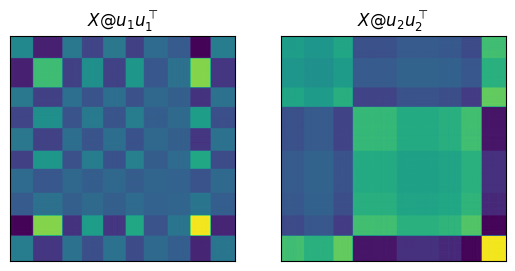

In [17]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(X0@X0.T)
ax2.imshow(X1@X1.T)

ax1.set_title(r'$X @ u_1 u_1^\top$')
ax2.set_title(r'$X @ u_2 u_2^\top$')

ax1.set_xticks([])
ax2.set_xticks([])
ax1.set_yticks([])
ax2.set_yticks([])

plt.show()